[changes since put online:
- correct a bug in configuration model networks for project 1
- corrected a typo in last bullet of project 2.
- made clearer that writing code from scratch may be best option in project 2
]

# Projects:

Please do one of the following 3 problems (note that Problem 1 gives the choice of two different scenarios.  If you choose Problem 1, you do not need to do both).

## Problem 1 (Contact tracing with Asymptomatic Transmissions)

Consider an infectious disease in which some individuals may transmit to their contacts even without showing symptoms.  There are two scenarios we will consider that can cause this.  You **have your choice of which scenario** to consider.


- **scenario 1** After becoming infected, individuals have an incubation period (E) prior to becoming symptomatic (I).  In that incubation period, they may be infectious.  After becoming symptomatic, they remain infectious until they recover (R) or are identified (T).  So without any intervention the transitions are S->E->I->R.  Symptomatic (I) individuals enter the additional traced/identified "T" class either because of their symptoms, or because an infected neighbor was identified and they were then traced.  The incubating individuals (E) can enter the traced/identified class (T) only by contact tracing from an identified neighbor.

- **scenario 2** After becoming infected, some individuals have a completely asymptomatic infection, while others are symptomatic.  Both may be infectious.  The symptomatic individuals (I_s) behave like the 'I' individuals above, and the asymptomatic individuals (I_a) behave like the 'E' individuals above.  The transitions here are S -> I_s -> R and S -> I_a -> R in absence of intervention.  With interventions I_s nodes are identified because of symptoms or because of contact tracing.  The I_a nodes are identified only through contact tracing.

We would like to know how well contact tracing works in these populations.  In both cases, individuals that have been identified are removed from the population (so they stop transmitting).  For each identified node, there is a period over which its infected neighbors may be identified.  During this period, the symptomatic and asymptomatic neighbors are found with some rate (per edge).  

You will need to simulate epidemics with these properties on various types of networks and write up a report to provide policy recommendations.  The code below will do the simulations.  This will not be as fast as some of the simulations we've used already, so don't be surprised if you need to use smaller networks.

Please explore a range of networks, including Watts-Strogatz and Configuration Model networks.   Also explore various parameters.  Report on 
- the impact of tracing compared to just isolating symptomatic individuals 
- under which conditions it would be better to invest resources in more efficient tracing versus more efficient identification of symptomatic individuals. 
- What network structures are more or less amenable to these control measures
- What assumptions are made that may limit the predictions you come up with.


<span style = 'color:red'> Note that we've discovered a bug if a node has an edge to itself, which can happen in Configuration Model networks.  This can be corrected with the following command right after `G` is defined: `G.remove_edges_from(list(G.selfloop_edges()))` </span>

In [29]:
import EoN
import networkx as nx
import random
import matplotlib.pyplot as plt

def SEIRT_with_contact_tracing(G, tau_E, tau_I, gamma_E, gamma_IT, gamma_IR, xi_T, zeta_T, rho):
    r'''
    Arguments:
    G - networkx graph
    tau_E - transmission rate of incubating/exposed individuals (E) to susceptible neighbors 
    tau_I - transmission rate of symptomatic individuals (I) to susceptible neighbors
    gamma_E - rate that individuals go from E to I
    gamma_IT - rate that individuals in I become identified due to symptoms (they move into T)
    gamma_IR - rate that individuals in I recover 
    xi_T - rate that an E or I neighbor of an identified individual with an identified neighbor is found due to contact tracing
    zeta_T rate at which the policy makers stop tracing contact of a given identified individual 
    rho - initial proportion infected (they all start in E)

    
    returns numpy arrays:
    
    t, S, E, I, R, Te, Ti  
    
    Here 'S' is the history of number susceptible, similarly for E, I, R.  Then Te gives counts of how many were identified 
    while in E and Ti gives counts of how many were identified while in I.
    
    The code is based on the simple contagion code in EoN.
    
    The full documentation is here: https://epidemicsonnetworks.readthedocs.io/en/latest/functions/EoN.Gillespie_simple_contagion.html
    '''
    
    #internally we have two traced classes: T1 and T2.  In T1, their neighbors are being actively traced.
    #in T2, we have stopped tracing their partners.  The transition is at rate zeta_T.  These are further subdivided
    #based on what state the node was in when identified.  This subdivision is just for book-keeping - it doesn't affect
    #the dynamics
    
    H = nx.DiGraph()  #this graph captures all of the transitions that can happen without an edge.
    H.add_edge('E', 'I', rate = gamma_E)
    H.add_edge('I', 'T1i', rate = gamma_IT)
    H.add_edge('I', 'R', rate = gamma_IR)
    H.add_edge('T1e', 'T2e', rate = zeta_T)
    H.add_edge('T1i', 'T2i', rate = zeta_T)

    
    J = nx.DiGraph()  #these are the transitions that happen because of an edge in the contact network.
    J.add_edge(('E', 'S'), ('E', 'E'), rate = tau_E)  #an E individual with an S neighbor can make the neighbor E.
    J.add_edge(('I', 'S'), ('I', 'E'), rate = tau_I)
    J.add_edge(('T1e', 'E'), ('T1e', 'T1e'), rate = xi_T)
    J.add_edge(('T1e', 'I'), ('T1e', 'T1s'), rate = xi_T)
    J.add_edge(('T1i', 'E'), ('T1i', 'T1e'), rate = xi_T)
    J.add_edge(('T1i', 'I'), ('T1i', 'T1i'), rate = xi_T)


    return_statuses = ('S', 'E', 'I', 'R', 'T1e', 'T2e', 'T1i', 'T2i')
    
    IC = {node:'S' for node in G.nodes()}  #cleaner to use a 'defaultdict', but sticking to this.
    for node in G.nodes():
        if random.random()<rho:
            IC[node] = 'E'
            
    t, S, E, I, R, T1e, T2e, T1i, T2i = EoN.Gillespie_simple_contagion(G, H, J, IC, return_statuses, tmax = float('Inf'))
    
    return t, S, E, I, R, T1e+T2e, T1i+T2i
 

[0 1 2 1 2 3 4 3 4 3 4 5 5 6 5 4 5 4 3 2 1 2 1 2 1 2 1 2 1 1 2 2 1 1 1 0 0
 0 0]
[15 14 13 13 12 11 10 10  9  9  8  7  7  6  6  6  5  5  5  5  5  4  4  3
  3  2  2  1  1  1  0  0  0  0  0  0  0  0  0]


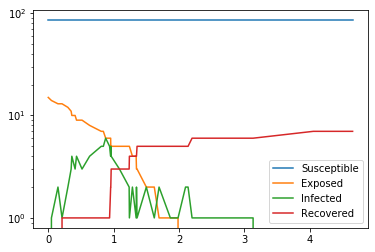

In [36]:
G = nx.erdos_renyi_graph(100, 0.2)
#G = nx.newman_watts_strogatz_graph(100, 5, 0.2, seed=None) #k=degree of nodes

G = nx.configuration_model(deg_dist)   
G.remove_edges_from(list(G.selfloop_edges()))
tau_E = 0.01 # transmission rate of incubating/exposed individuals (E) to susceptible neighbors 
tau_I = 0.01 # transmission rate of symptomatic individuals (I) to susceptible neighbors
gamma_E = 0.85 # rate that individuals go from E to I
gamma_IT = 0.7 # rate that individuals in I become identified due to symptoms (they move into T)
gamma_IR = 0.8 # rate that individuals in I recover 
xi_T = 0.3 # rate that an E or I neighbor of an identified individual with an identified neighbor is found due to contact tracing
zeta_T = 0.6 #rate at which the policy makers stop tracing contact of a given identified individual 
rho = 0.1

t, S, E, I, R, T1_e, T1_i = SEIRT_with_contact_tracing(G, tau_E, tau_I, gamma_E, gamma_IT, gamma_IR, xi_T, zeta_T, rho)

plt.semilogy(t, S, label = 'Susceptible')
plt.semilogy(t, E, label = 'Exposed')
plt.semilogy(t, I, label = 'Infected')
plt.semilogy(t, R, label = 'Recovered')
plt.legend()

print(I)
print(E)

In [2]:
import EoN
import networkx as nx
import random
import matplotlib.pyplot as plt

def SEIRT_with_contact_tracing(G, tau_E, tau_I, gamma_E, gamma_IT, gamma_IR, xi_T, zeta_T, rho):
    r'''
    Arguments:
    G - networkx graph
    tau_E - transmission rate of incubating/exposed individuals (E) to susceptible neighbors 
    tau_I - transmission rate of symptomatic individuals (I) to susceptible neighbors
    gamma_E - rate that individuals go from E to I
    gamma_IT - rate that individuals in I become identified due to symptoms (they move into T)
    gamma_IR - rate that individuals in I recover 
    xi_T - rate that an E or I neighbor of an identified individual with an identified neighbor is found due to contact tracing
    zeta_T rate at which the policy makers stop tracing contact of a given identified individual 
    rho - initial proportion infected (they all start in E)

    
    returns numpy arrays:
    
    t, S, E, I, R, Te, Ti  
    
    Here 'S' is the history of number susceptible, similarly for E, I, R.  Then Te gives counts of how many were identified 
    while in E and Ti gives counts of how many were identified while in I.
    
    The code is based on the simple contagion code in EoN.
    
    The full documentation is here: https://epidemicsonnetworks.readthedocs.io/en/latest/functions/EoN.Gillespie_simple_contagion.html
    '''
    
    #internally we have two traced classes: T1 and T2.  In T1, their neighbors are being actively traced.
    #in T2, we have stopped tracing their partners.  The transition is at rate zeta_T.  These are further subdivided
    #based on what state the node was in when identified.  This subdivision is just for book-keeping - it doesn't affect
    #the dynamics
    
    H = nx.DiGraph()  #this graph captures all of the transitions that can happen without an edge.
    H.add_edge('E', 'I', rate = gamma_E)
    H.add_edge('I', 'T1i', rate = gamma_IT)
    H.add_edge('I', 'R', rate = gamma_IR)
    H.add_edge('T1e', 'T2e', rate = zeta_T)
    H.add_edge('T1i', 'T2i', rate = zeta_T)

    
    J = nx.DiGraph()  #these are the transitions that happen because of an edge in the contact network.
    J.add_edge(('E', 'S'), ('E', 'E'), rate = tau_E)  #an E individual with an S neighbor can make the neighbor E.
    J.add_edge(('I', 'S'), ('I', 'E'), rate = tau_I)
    J.add_edge(('T1e', 'E'), ('T1e', 'T1e'), rate = xi_T)
    J.add_edge(('T1e', 'I'), ('T1e', 'T1s'), rate = xi_T)
    J.add_edge(('T1i', 'E'), ('T1i', 'T1e'), rate = xi_T)
    J.add_edge(('T1i', 'I'), ('T1i', 'T1i'), rate = xi_T)


    return_statuses = ('S', 'E', 'I', 'R', 'T1e', 'T2e', 'T1i', 'T2i')
    
    IC = {node:'S' for node in G.nodes()}  #cleaner to use a 'defaultdict', but sticking to this.
    for node in G.nodes():
        if random.random()<rho:
            IC[node] = 'E'
            
    t, S, E, I, R, T1e, T2e, T1i, T2i = EoN.Gillespie_simple_contagion(G, H, J, IC, return_statuses, tmax = float('Inf'))
    
    return t, S, E, I, R, T1e+T2e, T1i+T2i
    
def SIaIsRT_with_contact_tracing(G, asympt_probability, tau_Ia, tau_Is, gamma_IaR, gamma_IsT, gamma_IsR, xi_T, zeta_T, rho):
    r'''
    Arguments:
    G - networkx graph
    asympt_probability - probability a newly infected individual will be asymptomatic
    tau_E - transmission rate of asymptomatic infections (I_a)
    tau_I - transmission rate of symptomatic infections (I_s)
    gamma_IT - rate that individuals in I become identified due to symptoms
    gamma_IR - rate that individuals in I recover
    xi_T - rate that an E or I neighbor of an identified individual is identified due to contact tracing
    zeta_T rate at which the policy makers stop tracing contact of a given identified individual
    rho - initial proportion infected (all start E)

    
    returns numpy arrays:
    
    t, S, Ia, Is, Ra, Rs, Ta, Ts

    We distinguish 
    The code is based on the simple contagion code in EoN.
    
    The full documentation is here: https://epidemicsonnetworks.readthedocs.io/en/latest/functions/EoN.Gillespie_simple_contagion.html
    '''
    
    #internally we have two traced classes: T1 and T2.  In T1, their neighbors are being actively traced.
    #in T2, we have stopped tracing their partners.  The transition is at rate zeta_T.
    
    H = nx.DiGraph()  #this graph captures all of the transitions that can happen without an edge.
    H.add_edge('Is', 'T1', rate = gamma_IsT)
    H.add_edge('Ia', 'Ra', rate = gamma_IaR)
    H.add_edge('Is', 'Rs', rate = gamma_IsR)
    H.add_edge('T1', 'T2', rate = zeta_T)
    
    J = nx.DiGraph()  #these are the transitions that happen because of an edge in the contact network.
    J.add_edge(('Ia', 'S'), ('Ia', 'Ia'), rate = tau_Ia * asympt_probability)
    J.add_edge(('Ia', 'S'), ('Ia', 'Is'), rate = tau_Ia * (1-asympt_probability))
    J.add_edge(('Is', 'S'), ('Is', 'Ia'), rate = tau_Is * asympt_probability)
    J.add_edge(('Is', 'S'), ('Is', 'Ia'), rate = tau_Is * (1-asympt_probability))
    J.add_edge(('T1', 'Ia'), ('T1', 'T1'), rate = xi_T)
    J.add_edge(('T1', 'Is'), ('T1', 'T1'), rate = xi_T)


    return_statuses = ('S', 'Ia', 'Is', 'Ra', 'Rs', 'T1a', 'T2a', 'T1s', 'T2s')
    
    IC = {node:'S' for node in G.nodes()}  #cleaner to use a 'defaultdict', but sticking to this.
    for node in G.nodes():
        if random.random()<rho:
            if random.random()< asympt_probability:
                IC[node] = 'Ia'
            else:
                IC[node] = 'Is'

    t, S, Ia, Is, Ra, Rs, T1a, T2a, T1s, T2s = EoN.Gillespie_simple_contagion(G, H, J, IC, return_statuses, tmax = float('Inf'))
     
    return t, S, Ia, Is, Ra, Rs, T1a+T2a, T1s+T2s
    




## Problem 2 (idea spread)

The goal here is to understand how political beliefs establish themselves.

We consider two competing beliefs that spread within a population.  I'll use the term "issue" to describe the pair.  The beliefs each spread like the Watts Threshold Model, but once a node adopts one belief, it will not accept the other.  

We will let this issue spread through the population, and then introduce a second issue of 2 competing beliefs.  In the second issue, we assume people are inclined to believe those who agree with them on the first issue and to and not believe those who disagree on the first issue.

We will assume that the spread happens in discrete time.  You will need to write some code to produce the simulations (<span style="color:orange">
it may be easiest to do this from scratch rather than trying to adapt EoN</span>).  The code from the last assignment which dealt with introducing an intervention would be a good place to start.

- Start with a small fraction $\rho$ having each belief on the first issue.
- Set some threshold $r$ such that once $r$ neighbors have one belief or the other the node adopts that belief at the next time step.  If in a single time step, both beliefs cross the threshold, the node takes the most common belief among its neighbors, and if they are equal, it chooses one of them randomly.
- Run this until no more transitions happen.  There may be individuals who have no opinion at this point.  Reduce $r$ by one and run the simulation further (from the final state).  Keep going until $r=1$.
- We will start from this system state and simulate multiple scenarios.  Try to find a scenario where similar numbers hold each belief.
- Now introduce the second issue randomly again.  Set a threshold $r$.  Denote the two beliefs 'a' and 'b'.  A node will adopt 'a' (or 'b') if the number of those who agree with it on issue 1 who believe 'a' plus the number who disagree on issue ~~2~~ <span style="color:red">1</span> who believe 'b' crosses $r$.  As before, you'll need some form of tiebreaker.

Do we see strong correlations at the end between the beliefs on issue 1 and issue 2?  Try this with many network types (Configuration Model, Watts-Strogatz etc).  What changes?  What doesn't?  What network types are easy/hard to get equal numbers holding the same beliefs on issue 1?  Comment on what implications this might have for society.

## Problem 3 (your suggestions)

If you've got a problem that you would be interested in working on, I am open to suggestions.  
- You'll need to run it by me before working on it.
- I reserve the right to modify the things you do.
- I reserve the right to refuse if I feel it
  - is not challenging enough 
  - has too high of a risk that something won't work
  - or that I'm simply not qualified to judge it.